# **GROUP 8**
# **PROJECT 9**
# **HYBRID MULTIFREQUENCY ILLUSION IMAGE**


=== DOG/CAT (PSO optimized hybrid - COLOUR pipeline) ===


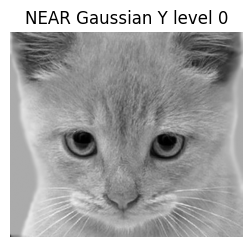

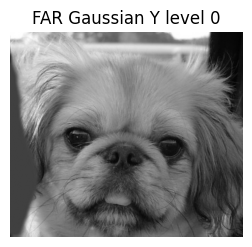

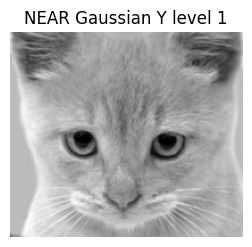

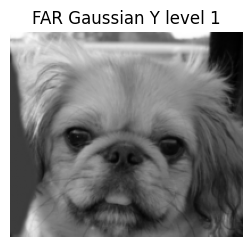

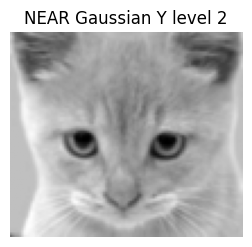

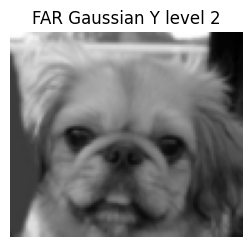

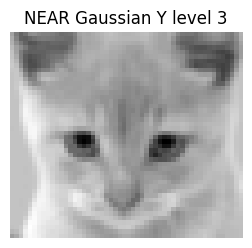

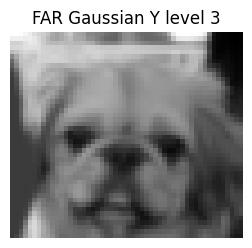

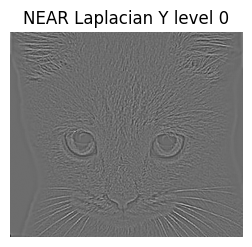

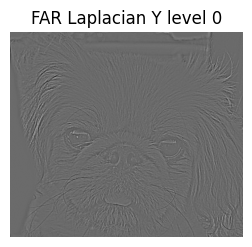

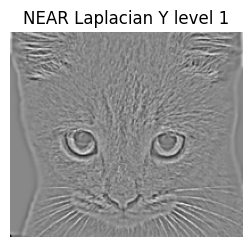

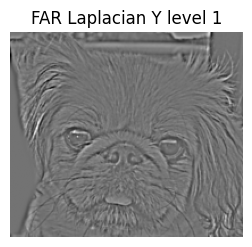

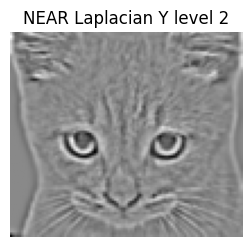

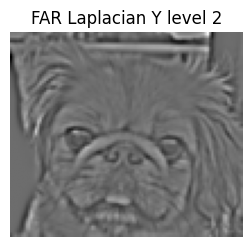

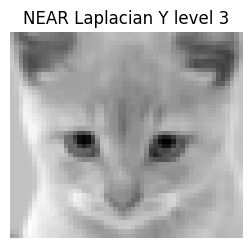

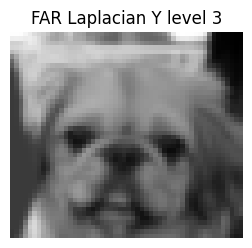

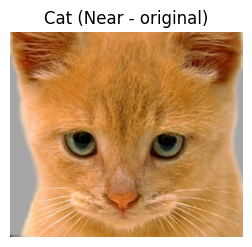

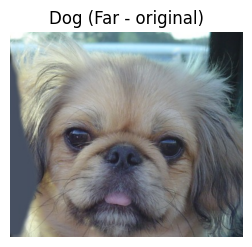

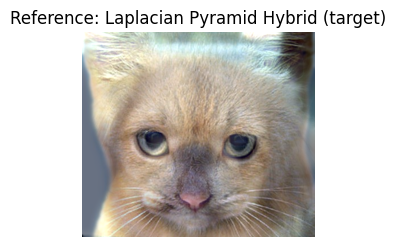

Starting PSO...
PSO iter 1/20 — best score: 0.9328 params: (0.6763800382614136, 2.1240477561950684, 1.3546833992004395, 0.5523700714111328)
PSO iter 5/20 — best score: 0.9504 params: (0.6641333125826501, 2.5, 1.0238459926594599, 0.47525479600362425)
PSO iter 10/20 — best score: 0.9510 params: (0.7443587677320299, 2.5, 1.0180666153188564, 0.30471352068042495)
PSO iter 15/20 — best score: 0.9510 params: (0.7615815382710084, 2.5, 1.0400468410813515, 0.3567225601667057)
PSO iter 20/20 — best score: 0.9511 params: (0.7574230785052831, 2.5, 1.0356267460597615, 0.35049166500768913)
PSO done in 6.3s, best score 0.9511


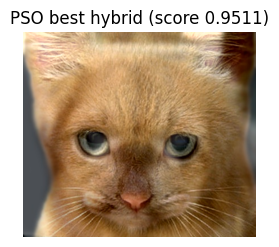

MSE: 1685.7998 SSIM: 0.9492239952087402

=== MARILYN/EINSTEIN (Gaussian YUV hybrid - GRAYSCALE visualization) ===


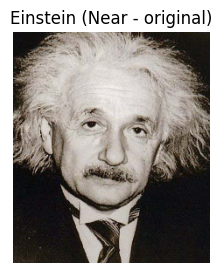

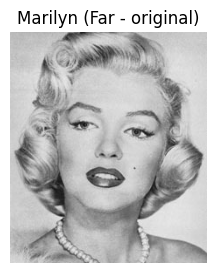

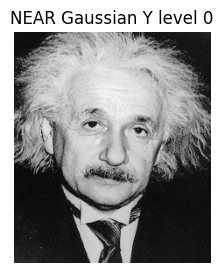

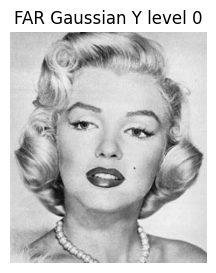

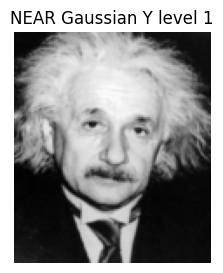

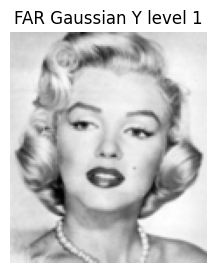

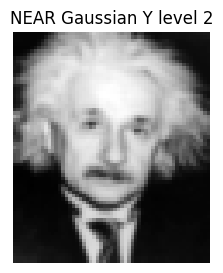

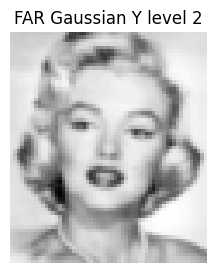

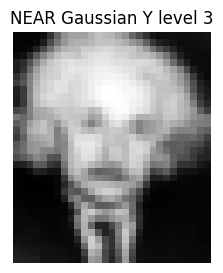

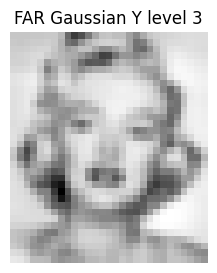

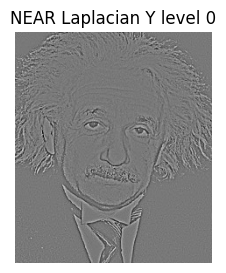

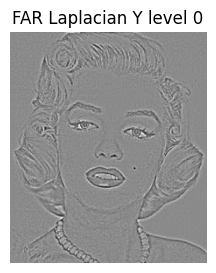

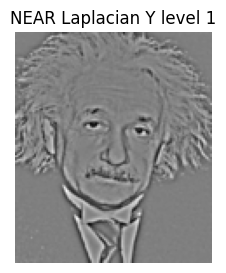

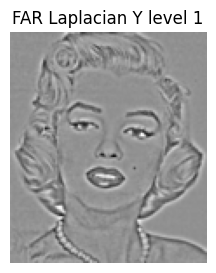

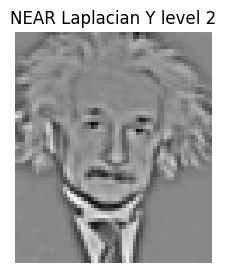

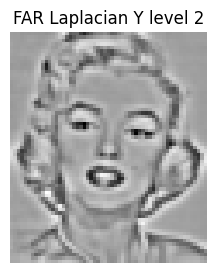

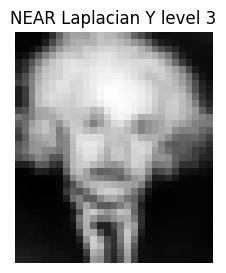

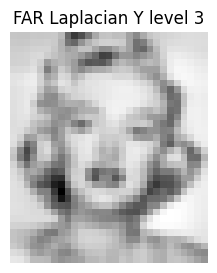

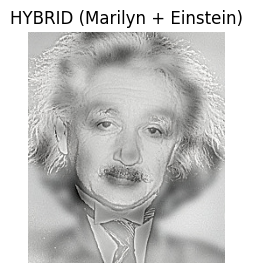

In [ ]:
"""
--> COLOR section and GRAYSCALE section

- Colour section:
    * colour helpers, YUV hybrids, Laplacian pyramid target, PSO optimizer
- Grayscale section:
    * grayscale SSIM & Y-channel pyramid visualization helpers

Shared utilities are at top.
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import random

# ------------------------------
# Paths
# ------------------------------
path_cat = "/content/cat.jpg"       # NEAR / high-frequency contributor (color)
path_dog = "/content/dog.jpg"       # FAR / low-frequency contributor (color)
path_mar = "/content/marilyn.jpg"   # FAR / low-frequency contributor (grayscale allowed)
path_ein = "/content/einstein.jpg"  # NEAR / high-frequency contributor (grayscale allowed)

# ------------------------------
# Shared utilities (both pipelines)
# ------------------------------
def show(img, title="", cmap=None, scale=4):
    """Display image (detects grayscale vs color)."""
    plt.figure(figsize=(scale, scale))
    if img is None:
        return
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        if img.dtype != np.uint8:
            disp = np.clip(img, 0, 255).astype(np.uint8)
        else:
            disp = img
        plt.imshow(cv2.cvtColor(disp, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def ensure_bgr(img):
    """If grayscale (H,W or H,W,1), convert to BGR. If already 3-ch, return copy."""
    if img is None:
        return None
    if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img.copy()

# ------------------------------
# ------------------------------
# COLOUR PIPELINE
# ------------------------------
# ------------------------------

# All functions here operate in color (BGR/YUV).
# Grayscale images are auto-converted to 3-channel BGR via ensure_bgr().


# --- float pyramids for color (per-channel float ops) ---
def gaussian_pyr_float(img, levels):
    """Gaussian pyramid for float (3-channel or single-channel floats allowed)."""
    g = [img]
    cur = img
    for _ in range(1, levels):
        cur = cv2.pyrDown(cur)
        g.append(cur)
    return g

def laplacian_pyr_float(img, levels):
    """Laplacian pyramid for float images (handles multi-channel)."""
    g = gaussian_pyr_float(img, levels)
    L = []
    for i in range(levels - 1):
        up = cv2.pyrUp(g[i+1], dstsize=(g[i].shape[1], g[i].shape[0]))
        # crop to match
        up = up[:g[i].shape[0], :g[i].shape[1], ...]
        L.append(g[i] - up)
    L.append(g[-1])
    return L

def reconstruct_from_laplacian_float(L):
    """Reconstruct float image from Laplacian pyramid."""
    img = L[-1]
    for i in range(len(L)-2, -1, -1):
        up = cv2.pyrUp(img, dstsize=(L[i].shape[1], L[i].shape[0]))
        up = up[:L[i].shape[0], :L[i].shape[1], ...]
        img = up + L[i]
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8)

# --- YUV parameterized hybrid builder (colour) ---
def build_hybrid_params(img_far_u8, img_near_u8,
                        sigma_low_mul=1.0, sigma_high_mul=1.0,
                        detail_strength=1.2, far_uv_weight=0.9):
    """
    img_far_u8, img_near_u8: uint8 images (BGR or grayscale)
    returns: resized far, resized near, hybrid_bgr, farY, nearY
    """
    # ensure BGR 3-channel
    img_far_u8 = ensure_bgr(img_far_u8)
    img_near_u8 = ensure_bgr(img_near_u8)

    # Resize to common shape (smallest dims)
    h = min(img_far_u8.shape[0], img_near_u8.shape[0])
    w = min(img_far_u8.shape[1], img_near_u8.shape[1])
    img_far = cv2.resize(img_far_u8, (w,h), interpolation=cv2.INTER_AREA)
    img_near = cv2.resize(img_near_u8, (w,h), interpolation=cv2.INTER_AREA)

    # Convert to YUV float (so we can blur/mix)
    far_yuv  = cv2.cvtColor(img_far,  cv2.COLOR_BGR2YUV).astype(np.float32)
    near_yuv = cv2.cvtColor(img_near, cv2.COLOR_BGR2YUV).astype(np.float32)

    farY, farU, farV   = cv2.split(far_yuv)
    nearY, nearU, nearV = cv2.split(near_yuv)

    H, W = farY.shape
    base = max(H, W)
    sigma_low  = max(0.1, base * 0.015 * float(sigma_low_mul))
    sigma_high = max(0.1, base * 0.006 * float(sigma_high_mul))

    # Low frequencies from far image
    Y_low  = cv2.GaussianBlur(farY, (0,0), sigma_low)

    # High frequencies from near image
    near_blur = cv2.GaussianBlur(nearY, (0,0), sigma_high)
    Y_high = nearY - near_blur

    Y_final = Y_low + detail_strength * Y_high
    Y_final = np.clip(Y_final, 0, 255)

    far_uv_weight = float(far_uv_weight)
    far_uv_weight = np.clip(far_uv_weight, 0.0, 1.0)
    U_final = far_uv_weight * farU + (1.0 - far_uv_weight) * nearU
    V_final = far_uv_weight * farV + (1.0 - far_uv_weight) * nearV

    # ensure uint8 merge shapes
    merged = cv2.merge([Y_final.astype(np.uint8),
                        U_final.astype(np.uint8),
                        V_final.astype(np.uint8)])
    hybrid_bgr = cv2.cvtColor(merged, cv2.COLOR_YUV2BGR)
    return img_far, img_near, hybrid_bgr, farY, nearY

# --- Laplacian-pyramid reference target (color float ops) ---
def create_pyramid_target(img_far_u8, img_near_u8, levels=4):
    """Create a Laplacian-pyramid fused reference image (colour)."""
    img_far = ensure_bgr(img_far_u8)
    img_near = ensure_bgr(img_near_u8)

    h = min(img_far.shape[0], img_near.shape[0])
    w = min(img_far.shape[1], img_near.shape[1])
    far_f = cv2.resize(img_far, (w,h)).astype(np.float32)
    near_f = cv2.resize(img_near, (w,h)).astype(np.float32)

    lap_far = laplacian_pyr_float(far_f, levels)
    lap_near = laplacian_pyr_float(near_f, levels)
    fused = []
    n = len(lap_far)
    for i in range(n):
        # example asymmetric weighting (near dominates detail, far dominates base)
        if i < n-1:
            band = 1.0 * lap_near[i] + 0.2 * lap_far[i]
        else:
            band = 1.0 * lap_far[i] + 0.2 * lap_near[i]
        fused.append(band)
    hybrid = reconstruct_from_laplacian_float(fused)
    hybrid = cv2.resize(hybrid, (w,h), interpolation=cv2.INTER_LINEAR)
    return hybrid

# --- Compact PSO ---
class SimplePSO:
    def __init__(self, n_particles, dim, bounds_min, bounds_max,
                 w=0.7, c1=1.4, c2=1.4, seed=None):
        self.n = int(n_particles)
        self.dim = int(dim)
        self.bounds_min = np.array(bounds_min, dtype=np.float32)
        self.bounds_max = np.array(bounds_max, dtype=np.float32)
        self.w = float(w); self.c1 = float(c1); self.c2 = float(c2)
        if seed is not None:
            random.seed(seed); np.random.seed(seed)
        # initialize positions/velocities
        self.pos = np.zeros((self.n, self.dim), dtype=np.float32)
        self.vel = np.zeros_like(self.pos)
        for i in range(self.n):
            r = np.random.rand(self.dim)
            self.pos[i] = self.bounds_min + r * (self.bounds_max - self.bounds_min)
            self.vel[i] = 0.05 * (np.random.rand(self.dim)*2 - 1) * (self.bounds_max - self.bounds_min)
        self.pbest_pos = self.pos.copy()
        self.pbest_val = np.full(self.n, np.inf, dtype=np.float32)
        self.gbest_pos = None
        self.gbest_val = np.inf
        self.gbest_info = None

    def step(self, eval_fn):
        # evaluate particles
        for i in range(self.n):
            val, info = eval_fn(self.pos[i])
            if val < self.pbest_val[i]:
                self.pbest_val[i] = val
                self.pbest_pos[i] = self.pos[i].copy()
            if val < self.gbest_val:
                self.gbest_val = val
                self.gbest_pos = self.pos[i].copy()
                self.gbest_info = info
        # update velocities & positions
        r1 = np.random.rand(self.n, self.dim)
        r2 = np.random.rand(self.n, self.dim)
        cognitive = self.c1 * r1 * (self.pbest_pos - self.pos)
        social = self.c2 * r2 * (self.gbest_pos[None, :] - self.pos)
        self.vel = self.w * self.vel + cognitive + social
        self.pos = self.pos + self.vel
        # clamp positions to bounds
        self.pos = np.minimum(np.maximum(self.pos, self.bounds_min[None,:]), self.bounds_max[None,:])
        return self.gbest_val, self.gbest_info

def make_eval_fn(img_far_u8, img_near_u8, hybrid_target):
    """
    Returns an eval function that maps a 4-d position to (value, info)
    where value is the scalar to minimize (-score) and info contains the
    generated colour image and scores.
    """
    def eval_pos(pos):
        p = np.array(pos).ravel()
        # extract params
        sigma_low_mul = float(p[0])
        sigma_high_mul = float(p[1])
        detail_strength = float(p[2])
        far_uv_weight = float(p[3])
        # clamp
        sigma_low_mul = max(0.2, min(3.0, sigma_low_mul))
        sigma_high_mul = max(0.2, min(3.0, sigma_high_mul))
        detail_strength = max(0.0, min(5.0, detail_strength))
        far_uv_weight = max(0.0, min(1.0, far_uv_weight))
        try:
            _, _, cand_bgr, _, _ = build_hybrid_params(
                img_far_u8, img_near_u8,
                sigma_low_mul=sigma_low_mul,
                sigma_high_mul=sigma_high_mul,
                detail_strength=detail_strength,
                far_uv_weight=far_uv_weight
            )
            # The structural_similarity function lives in the GRAYSCALE section,
            # but it accepts color images and converts to grayscale internally.
            ssim = structural_similarity(cand_bgr, hybrid_target)
            cand_gray = to_gray_u8(cand_bgr)
            contrast = float(np.std(cand_gray))
            contrast_score = min(1.0, contrast/50.0)
            total_score = 0.9 * ssim + 0.1 * contrast_score
            # minimize negative (so lower is better)
            return -float(total_score), {
                "score": float(total_score),
                "ssim": float(ssim),
                "contrast_score": float(contrast_score),
                "params": (sigma_low_mul, sigma_high_mul, detail_strength, far_uv_weight),
                "image": cand_bgr
            }
        except Exception as e:
            return 1e6, {"score": 0.0, "error": str(e), "image": np.zeros_like(img_far_u8)}
    return eval_pos

# ------------------------------
# ------------------------------
# GRAYSCALE PIPELINE
# ------------------------------
# ------------------------------

# Functions here operate on single-channel data (grayscale), or accept color but convert to grayscale for the metric.

def to_gray_u8(img):
    """Convert image (color or grayscale floats/uint8) to uint8 grayscale."""
    if img is None:
        return None
    if img.ndim == 3:
        return cv2.cvtColor(np.clip(img,0,255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    return np.clip(img,0,255).astype(np.uint8)

def structural_similarity(a, b):
    """
    Small SSIM-like function that converts inputs to grayscale uint8 internally.
    Returns a scalar similarity in roughly the SSIM range (but not canonical).
    """
    a_gray = to_gray_u8(a)
    b_gray = to_gray_u8(b)
    a_f = a_gray.astype(np.float32)
    b_f = b_gray.astype(np.float32)
    mu1 = cv2.GaussianBlur(a_f, (11,11), 1.5)
    mu2 = cv2.GaussianBlur(b_f, (11,11), 1.5)
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.GaussianBlur(a_f*a_f, (11,11), 1.5) - mu1_sq
    sigma2_sq = cv2.GaussianBlur(b_f*b_f, (11,11), 1.5) - mu2_sq
    sigma12 = cv2.GaussianBlur(a_f*b_f, (11,11), 1.5) - mu1_mu2
    C1 = (0.01*255)**2
    C2 = (0.03*255)**2
    denom = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2) + 1e-12
    ssim_map = ((2*mu1_mu2 + C1) * (2*sigma12 + C2)) / denom
    return float(np.mean(ssim_map))

# --- Gaussian / Laplacian pyramids for single-channel Y (display helpers) ---
def gaussian_pyr(channel, levels):
    """Single-channel gaussian pyramid (uint8 or float allowed)."""
    pyr = [channel]
    for _ in range(1, levels):
        channel = cv2.pyrDown(channel)
        pyr.append(channel)
    return pyr

def laplacian_pyr(channel, levels):
    """Single-channel laplacian pyramid (float or uint8 -> diff)."""
    g = gaussian_pyr(channel, levels)
    L = []
    for i in range(levels - 1):
        up = cv2.pyrUp(g[i+1], dstsize=(g[i].shape[1], g[i].shape[0]))
        up = up[:g[i].shape[0], :g[i].shape[1]]
        L.append(g[i] - up)
    L.append(g[-1])
    return L

def vis_lap(lvl):
    """Normalize a laplacian band for display as uint8."""
    x = lvl.astype(np.float32)
    x = x - x.min()
    if x.max() > 0:
        x = 255.0 * x / x.max()
    return np.clip(x,0,255).astype(np.uint8)

def visualize_Y_pyramids(Y_far, Y_near, levels=4):
    """Show gaussian and laplacian pyramids for the Y (single-channel) inputs."""
    g_far  = gaussian_pyr(Y_far,  levels)
    g_near = gaussian_pyr(Y_near, levels)
    for i in range(levels):
        show(np.clip(g_near[i],0,255).astype(np.uint8), f"NEAR Gaussian Y level {i}", cmap="gray", scale=3)
        show(np.clip(g_far[i],0,255).astype(np.uint8),  f"FAR Gaussian Y level {i}", cmap="gray", scale=3)
    lap_far  = laplacian_pyr(Y_far,  levels)
    lap_near = laplacian_pyr(Y_near, levels)
    for i in range(levels):
        show(vis_lap(lap_near[i]), f"NEAR Laplacian Y level {i}", cmap="gray", scale=3)
        show(vis_lap(lap_far[i]),  f"FAR Laplacian Y level {i}", cmap="gray", scale=3)

#--------------------------
# Main
#--------------------------
if __name__ == "__main__":

    cat = cv2.imread(path_cat, cv2.IMREAD_UNCHANGED)
    dog = cv2.imread(path_dog, cv2.IMREAD_UNCHANGED)
    mar = cv2.imread(path_mar, cv2.IMREAD_UNCHANGED)
    ein = cv2.imread(path_ein, cv2.IMREAD_UNCHANGED)

    # --- COLOUR pipeline: DOG/CAT pair with PSO optimization ---
    if cat is None or dog is None:
        print("Skipping DOG/CAT (colour PSO) — images not found.")
    else:
        print("\n=== DOG/CAT (PSO optimized hybrid - COLOUR pipeline) ===")
        # ensure same base size
        h = min(cat.shape[0], dog.shape[0])
        w = min(cat.shape[1], dog.shape[1])
        cat_r = cv2.resize(cat, (w,h), interpolation=cv2.INTER_AREA)
        dog_r = cv2.resize(dog, (w,h), interpolation=cv2.INTER_AREA)

        # Levels for pyramid visualization and target creation
        LEVELS = 4

        # Build a quick Y-channel pair for level visualization
        _, _, _, Y_far_dc, Y_near_dc = build_hybrid_params(dog_r, cat_r)
        visualize_Y_pyramids(Y_far_dc, Y_near_dc, levels=LEVELS)

        hybrid_target = create_pyramid_target(dog_r, cat_r, levels=LEVELS)
        show(cat_r, "Cat (Near - original)", scale=3)
        show(dog_r, "Dog (Far - original)", scale=3)
        show(hybrid_target, "Reference: Laplacian Pyramid Hybrid (target)", scale=3)

        # PSO settings (tune if needed)
        N_PARTICLES = 20
        N_ITERS = 20
        seed = 123
        bounds_min = np.array([0.3, 0.3, 0.0, 0.0], dtype=np.float32)
        bounds_max = np.array([2.5, 2.5, 4.0, 1.0], dtype=np.float32)
        pso = SimplePSO(N_PARTICLES, dim=4, bounds_min=bounds_min, bounds_max=bounds_max,
                        w=0.7, c1=1.2, c2=1.2, seed=seed)
        eval_fn = make_eval_fn(dog_r, cat_r, hybrid_target)
        print("\n----- Starting PSO ------\n")
        t0 = time.time()
        for it in range(N_ITERS):
            gbest_val, ginfo = pso.step(eval_fn)
            best_score = -pso.gbest_val if pso.gbest_val != np.inf else float("-inf")
            if (it+1) % 5 == 0 or it == 0 or it == N_ITERS-1:
                print(f"PSO iter {it+1}/{N_ITERS} — best score: {best_score:.4f} params: {pso.gbest_info['params'] if pso.gbest_info else None}")
        print(f"PSO done in {time.time()-t0:.1f}s, best score {(-pso.gbest_val):.4f}")
        best_image = pso.gbest_info["image"]
        show(best_image, f"PSO best hybrid (score {pso.gbest_info['score']:.4f})", scale=3)

        # quantitative
        mse_val = np.mean((hybrid_target.astype(np.float32) - best_image.astype(np.float32))**2)
        ssim_val = structural_similarity(hybrid_target, best_image)
        print("MSE:", mse_val, "SSIM:", ssim_val)

    # --- GRAYSCALE pipeline ---
    # Note: build_hybrid_simple returns colour hybrid but is used to extract Y for grayscale visualization.
    if mar is None or ein is None:
        print("Skipping MARILYN/EINSTEIN (grayscale demo) — images not found.")
    else:
        print("\n=== MARILYN/EINSTEIN (Gaussian YUV hybrid - GRAYSCALE visualization) ===")
        far_mar, near_ein, hybrid_me, Y_far_me, Y_near_me = build_hybrid_simple(mar, ein)
        # show NEAR then FAR (as you requested)
        show(near_ein, "Einstein (Near - original)", scale=3)
        show(far_mar, "Marilyn (Far - original)", scale=3)
        visualize_Y_pyramids(Y_far_me, Y_near_me, levels=4)
        show(hybrid_me, "HYBRID (Marilyn + Einstein)", scale=3)



def build_hybrid_simple(img_far, img_near):
    # ensure BGR so YUV ops work
    img_far = ensure_bgr(img_far)
    img_near = ensure_bgr(img_near)
    h = min(img_far.shape[0], img_near.shape[0])
    w = min(img_far.shape[1], img_near.shape[1])
    img_far = cv2.resize(img_far, (w,h))
    img_near = cv2.resize(img_near, (w,h))
    far_yuv  = cv2.cvtColor(img_far,  cv2.COLOR_BGR2YUV).astype(np.float32)
    near_yuv = cv2.cvtColor(img_near, cv2.COLOR_BGR2YUV).astype(np.float32)
    farY, farU, farV   = cv2.split(far_yuv)
    nearY, nearU, nearV = cv2.split(near_yuv)
    H, W = farY.shape
    base = max(H, W)
    sigma_low  = base * 0.015
    sigma_high = base * 0.006
    Y_low  = cv2.GaussianBlur(farY, (0,0), sigma_low)
    near_blur = cv2.GaussianBlur(nearY, (0,0), sigma_high)
    Y_high = nearY - near_blur
    detail_strength = 1.2
    Y_final = Y_low + detail_strength * Y_high
    Y_final = np.clip(Y_final, 0, 255)
    U_final = 0.9 * farU + 0.1 * nearU
    V_final = 0.9 * farV + 0.1 * nearV
    hybrid_yuv = cv2.merge([Y_final, U_final, V_final]).astype(np.uint8)
    hybrid_bgr = cv2.cvtColor(hybrid_yuv, cv2.COLOR_YUV2BGR)
    return img_far, img_near, hybrid_bgr, farY, nearY